In [1]:
# import modules
from qutip import *
import numpy as np
from scipy.linalg import logm, expm, inv
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from itertools import product
from IPython.display import display, Latex
import importlib
import pickle
import time
import random
import os

# define identity for qubits 
I2 = qeye(2)

# define Pauli matrices and constants
σ_x = sigmax()
σ_y = sigmay()
σ_z = sigmaz()
π = np.pi

# font specs for plots
%matplotlib inline
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.size"] = "14"

In [2]:
def spin_chain_quantities(N, Jx, Jy, Jz, periodic_bc, tolerance):

    
    if N % 2 != 0: 
        raise ValueError("Please enter an even number of sites")
    
    # define Pauli matrices and constants
    σ_x = sigmax()
    σ_y = sigmay()
    σ_z = sigmaz()
    π = np.pi

    # Interaction coefficients, which we assume are uniform throughout the lattice
    Jx_list = Jx*np.ones(N)
    Jy_list = Jy*np.ones(N)
    Jz_list = Jz*np.ones(N)

    # Setup operators for individual qubits; 
    # here sx_list[j] = X_j, sy_list[j] = Y_j, and sz_list[j] = Z_j
    # since the Pauli matrix occupies the jth location in the tensor product of N terms
    # of which N-1 terms are the identity
    sx_list, sy_list, sz_list = [], [], []

    for i in range(N):
        op_list = [qeye(2)]*N
        op_list[i] = σ_x
        sx_list.append(tensor(op_list))
        op_list[i] = σ_y
        sy_list.append(tensor(op_list))
        op_list[i] = σ_z
        sz_list.append(tensor(op_list))

    # define variable for total Hamiltonian H_N and the list of all local 
    # Hamiltonians H_list
    H_N = 0 
    H_list = []
    
    # collect 
    for j in range(N - 1):

        # find H_ij, the Hamiltonian between the ith and jth sites 
        H_ij = Jx_list[j] * sx_list[j] * sx_list[j + 1] + \
               Jy_list[j] * sy_list[j] * sy_list[j + 1] + \
               Jz_list[j] * sz_list[j] * sz_list[j + 1]
        
        # add H_ij to H_N and append H_ij to H_list
        H_N += H_ij
        H_list.append(H_ij)

    # execute if periodic boundary conditions are specified
    if periodic_bc: 
        
        # find H_N1, the Hamiltonian between the Nth and first site
        H_N1 = Jx_list[N-1] * sx_list[N - 1] * sx_list[0] + \
               Jy_list[N-1] * sy_list[N - 1] * sy_list[0] + \
               Jz_list[N-1] * sz_list[N - 1] * sz_list[0]

        # add H_N1 to H_N and append H_N1 to H_list
        H_N += H_N1
        H_list.append(H_N1)

    # find eigenavlues and eigenstates of Hamiltonian 
    eigenvalues, eigenstates = H_N.eigenstates()

    # find indices of smallest eigenvalues, which correspond to the energy(ies) 
    # of the ground state (space in the case of degeneracy); 
    min_eigenvalue = min(eigenvalues)
    indices = [index for index, value in enumerate(eigenvalues) if np.allclose(value, min_eigenvalue, tolerance)]

    # find eigenstates corresponding to ground state
    eigenstates_list = eigenstates[indices]

    # create sum of density matrices of ground states in case ground state is degenerate
    ρ_ground_state = 0 
    for j in range(len(eigenstates_list)):
        ρ_ground_state += (eigenstates_list[j])*(eigenstates_list[j]).dag()

    # return normalized ground state
    return H_N, H_list, eigenstates, eigenvalues, min_eigenvalue, ρ_ground_state

In [3]:
def generate_initial_states(N_cavities, N_qubits, num_states, cutoff):
    
    '''
    generate list of initial states which is a product of state of 
    the number of cavities and qubits specified by the arguments
    '''
    
    if N_cavities == 0 and cutoff == 0: 
        return [tensor([rand_ket(2) for i in range(N_qubits)]) \
                for initial_state in range(num_states)]
    else:

        # returns a product state of (N_cavities) cavities and (N_qubits) 
        # random qubits for specified number of initial states
        return [tensor([basis(cutoff, 0)]*N_cavities + [rand_ket(2) \
                for i in range(N_qubits)]) \
                for initial_state in range(num_states)]

In [4]:
def plot_fidelity(N_cavities, N_qubits, eigenvalues, eigenstates, m_start, m_stop, α_start, α_end, α_steps, \
                  initial_state_list, cutoff, save_file):

    # define vacuum state for a cavity, and spin up and spin down states for qubits
    vacuum = tensor([basis(cutoff, 0)]*(N_cavities))

    # list of numbers of cavities we will project onto the ground state
    if m_start >= 1 and m_stop <= N_qubits and m_stop <= N_cavities: 
        cavity_list = list(range(m_start, m_stop+1))
    else: 
        print("Please enter valid list of the number of cavities to project onto vacuum.")
        return

    # create array over which to sweep α
    α_array = np.linspace(α_start, α_end, α_steps)

    # calcuate the amount each state will be displaced 
    shifted_eigenvalues = eigenvalues - eigenvalues[0]
    
    # find the probability amplitudes for projecting onto each eigenstate in our eigenbasis for every initial state
    prob_amps_list = [[fidelity(state, tensor(vacuum, eigenstate))**2 for eigenstate in eigenstates] \
                      for state in initial_state_list]
    
    # collect the probability amplitudes associated with projecting onto the eigenstates in the groundstate 
    # (or groundspace) for every initial state
    gs_prob_amps_list = [[prob_amps for λ, prob_amps in zip(shifted_eigenvalues, prob_amps) if round(λ, 9) == 0] \
                         for prob_amps in prob_amps_list]

    # calcuate the success probability of being in the ground state after projecting onto vacuum
    fidelity_array_list = [[[sum(gs_prob_amps)/(sum([np.exp(-(m*(λ*α)**2))*prob_amp \
                               for λ, prob_amp in zip(shifted_eigenvalues, prob_amps)])) \
                               for α in α_array] \
                               for m in cavity_list]
                               for gs_prob_amps, prob_amps in zip(gs_prob_amps_list, prob_amps_list)] 

    # Generate unique colors using the 'tab10' color map
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']
        
    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5)]
    
    # create plot with axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # graph the theoretical projection of all initial states onto the true ground state 
    for i in range(len(fidelity_array_list)):
        for j, fidelity_array in enumerate(fidelity_array_list[i]):
            ax.plot(α_array, fidelity_array, \
                    label=f'Cavities =  {cavity_list[j]}, $F_0$ = {fidelity_array[0] :.3f}', \
                    color=colors[i], linestyle='-', dashes = dashed_list[(len(cavity_list) - 1) - j])

    ax.set_xlabel(r'$\alpha$', fontsize=15)
    ax.set_ylabel('Fidelity', fontsize=15)
    ax.set_title(f'Theoretical GSP Fidelity for {N_qubits} Sites', fontsize=17.5) 
    ax.legend(fontsize = 12.5)
    ax.grid(True)

## $\hat{H}_2 = X_1 X_2 + Y_1 Y_2 + \lambda Z_1 Z_2 $

In [5]:
# specify parameters of 2-site spin chain
N = 2
Jx = 1
Jy = 1
Jz = 1
periodic_bc = False
tolerance = 1e-12

# calculate spin chain quantities
# calculate spin chain quantities
H2, H2_list, eigenstates2, eigenvalues2, min_eigenvalue2, ρ_ground_state2 = \
    spin_chain_quantities(N, Jx, Jy, Jz, periodic_bc, tolerance)

In [6]:
# define singlet and triplet states
S = eigenstates2[0]
T0 = eigenstates2[3]
Tn1 = eigenstates2[2]
T1 = eigenstates2[1]

# create basis of singlets and triplets
ST_basis = [S, Tn1, T0, T1]

# create matrix with S, Tn1, T0 and T1 as column vectors 
ST_matrix = Qobj(np.hstack([eigenstate.full() for eigenstate in ST_basis]))
display(ST_matrix)

# eigenvalues for 2-site spin chain
display(eigenvalues2)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          1.        ]
 [-0.70710678  0.          0.70710678  0.        ]
 [ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          1.          0.          0.        ]]

array([-3.,  1.,  1.,  1.])

# $\hat{H}_4 = \sum_{j = 1}^{4} X_j X_{j+1} + Y_j Y_{j+1} + \lambda Z_j Z_{j+1} $

In [7]:
def eigendecomp_spin_operators(N, ST_basis):
    
    '''
    function to find the global eigenkets for blue and red bonds as well
    as the spectrum of each local 2-site Hamiltonian in the basis of these
    global eigenkets
    '''
    
    # collect indices for H_ik Hamiltonians which will be used to convert 
    # blue global eigenkets to red global eigenkets
    H_ik_indices = [(2 + i, N - i) for i in range(0, int(N/2) - 1)]

    # collect all H_ik matrices, which are Hamiltonians containing 
    # XX + YY + ZZ at indices i and k specified by each tuple in H_SWAP_indices
    H_ik_list = []
    for indices_tuple in H_ik_indices:

        # collect at which sites we will insert Pauli matrices
        site1 = indices_tuple[0]
        site2 = indices_tuple[1]

        # define list of identity operators and insert Pauli matrices
        # at sites specified by indices_tuple
        op_list = [qeye(2)]*N
        op_list[site1 - 1] = σ_x
        op_list[site2 - 1] = σ_x
        HX_couplings = tensor(op_list)
        op_list[site1 - 1] = σ_y
        op_list[site2 - 1] = σ_y
        HY_couplings = tensor(op_list)
        op_list[site1 - 1] = σ_z
        op_list[site2 - 1] = σ_z
        HZ_couplings = tensor(op_list) 

        # append H_SWAP = HX_couplings + HY_couplings + HZ_couplings to H_ik_list
        H_ik_list.append(HX_couplings + HY_couplings + HZ_couplings)

    # collect product of SWAP matrices that will convert red eigenkets to blue eigenkets
    I = tensor([qeye(2)]*N)
    dim = 2**N
    SWAP_operator = Qobj(reduce(lambda x,y: x*y, \
                                [(H_ik + I)/2 for H_ik in H_ik_list]), dims = [[dim], [dim]])

    # construct global eigenkets for red and blue bonds for N sites
    blue_mpsN = [Qobj(eigvec) for eigvec in reduce(np.kron, [ST_basis]*(int(N/2)))]
    red_mpsN = [SWAP_operator(Qobj(eigvec)) for eigvec in reduce(np.kron, [ST_basis]*(int(N/2)))]
    
    # initialize empty list which will contain the spectrum of each local Hamiltonian 
    # in the basis of the blue and red global eigenkets
    H_local_spectrum_list = []

    # find spectra of all 2-site Hamiltonians
    for i in range(1, N+1, 2):

        # compute spectrum from tensor products of index 1 to i 
        Hij_spectrum_1i = np.tile(eigenvalues2, 2**(i-1))

        # compute spectrum of tensor products of inex 1 to N, i.e., the full spectrum
        Hij_spectrum_1N = np.repeat(Hij_spectrum_1i, np.ceil(2**(N - i - 1)))

        # append to Hij_spectrum_list
        H_local_spectrum_list.append(Hij_spectrum_1N)

    # extra spectra for blue and red bonds according to previous ordering of eigenkets
    blue_spectraN = H_local_spectrum_list
    red_spectraN = H_local_spectrum_list[::-1]

    return blue_spectraN, blue_mpsN, red_spectraN, red_mpsN

In [8]:
def compute_VTA_list(α_start, α_end, α_steps):
    
    '''
    function finds the list of vacuum transition amplitudes for each α in α_array so that
    VTA_list = [<0000 | GSP(α, λ, E_0) |0000> for α in α_array]
    '''
    
    # start the timer for the operation 
    start_time = time.time()
    
    # define array over which we will sweep α
    α_array = np.linspace(α_start, α_end, α_steps)
    
    # define Gaussian weight tensor which is a function of the eigenvalues of 
    # each local Hamiltonian
    W4 = lambda α, i, j, k, l: np.exp(-((α**2)/2)*(a[i] + b[j] + c[k] + d[l])**2)
    
    # calculate the vacuum transition amplitude for N = 4
    VTA_list = []
    for α in α_array: 
        VTA = sum(
                W4(α, k0, k3, k2, k1)*W4(α, k0, k1, k2, k3) * \
                W4(α, k2, k1, k0, k3)*W4(α, k2, k3, k0, k1) * \
                (ν4_bras[k3]*μ4_kets[k2])*(μ4_bras[k2]*ν4_kets[k1]) * \
                (ν4_bras[k1]*μ4_kets[k0])*(ν4_kets[k3]*μ4_bras[k0])  
                for k3 in range(len(d)) \
                for k2 in range(len(c)) \
                for k1 in range(len(b)) \
                for k0 in range(len(a)) \
                )
        # adjust dimensions of VTA and append to VTA_list
        VTA_adjusted = Qobj(VTA, dims = [[2]*4, [2]*4])
        VTA_list.append(VTA_adjusted)
        
#     # Saving the list of quantum objects to a file
#     path = os.getcwd() + f'/four_site_data/VTA{N}_GWT_{α_start}_{α_end}_{α_steps}.pkl'

#     # save VTA_list to directory specified by path 
#     with open(path, 'wb') as file:
#         pickle.dump(VTA_list, file)
        
    # to upload saved data use following code
#     with open(path, 'rb') as file:
#         VTA_list_new = pickle.load(file)
        
    print("%s seconds" % (time.time() - start_time))
    return VTA_list

In [9]:
def plot_GSP_data(ψ0_list, VTA_list, α_start, α_end, α_steps, m_start, m_stop, save_file): 
    
    # define array over which we will plot α
    α_array = np.linspace(α_start, α_end, α_steps)

    # define list of colors to use for plots 
    colors = ['blue', 'orange', 'green','red', 'purple', 'black', 'pink', 'gray', 'cyan', 'magenta']
    
    # compute list of projection fidelity for VTA_list for all initial states in ψ0_list
    GSP_fidelity_array_list = [[expect(ρ_ground_state4, (VTA*ψ0).unit()) for VTA in VTA_list] \
           for ψ0 in ψ0_list]

    # generate custom linestyles to use if we are projecting 4 or more cavities onto vacuum
    dashed_list = [(None, None), (5, 2), (1, 2), (5, 2, 1, 2), (10, 5, 2, 5), \
                   (2, 2, 10, 2), (5, 2, 10, 2, 5, 2), (15, 5, 5, 5), (2, 5, 10, 5)]

    fig, ax = plt.subplots(figsize=(8, 6))

    # graph the theoretical projection of all initial states onto the true ground state 
    for i, fidelity_array in enumerate(GSP_fidelity_array_list): 
        ax.plot(α_array, fidelity_array, label=f'Trotterized, M = 4, $F_0$ = {fidelity_array[0] : .3f}', \
                color=colors[i], linestyle='-')

    ax.set_xlabel(r'$\alpha$', fontsize=15)
    ax.set_ylabel('Fidelity', fontsize=15)
    ax.set_title(f'Trotterized GSP with r = {1} for N = 4', fontsize=17.5)  
    ax.legend(fontsize = 12.5)
    ax.grid(True)
    
    if save_file: 
    
        # define which folder subfolder in /data to store the image
        if N_qubits == 2: 
            site_folder = 'two_sites'
        elif N_qubits == 3: 
            site_folder = 'three_sites'
        elif N_qubits == 4: 
            site_folder = 'four_sites'
        elif N_qubits == 5: 
            site_folder = 'five_sites'

        # calculate number of states that were simulated
        num_states = len(ψ0_list)

        if m_start != m_stop: 

            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}{m_stop}_r{r}.png'

            # Check if the file already exists
            if os.path.exists(filename):
                # If it exists, remove it
                os.remove(filename)

            # save figure 
            plt.savefig(filename)

        elif m_start == m_stop: 
            
            # create name for png file 
            filename = f'/Users/lukebell/Documents/boson_gang/data/{site_folder}/simulated_' \
                        f's{num_states}_m{m_start}_r{r}.png'

        # Check if the file already exists
        if os.path.exists(filename):
            # If it exists, remove it
            os.remove(filename) 

        # save figure 
        plt.savefig(filename)

In [10]:
# specify parameters of spin chain 
N = 4
Jx = 1
Jy = 1
Jz = 1
periodic_bc = True
tolerance4 = 1e-12

# calculate spin chain quantities
H4, H4_list, eigenstates4, eigenvalues4, E_0, ρ_ground_state4 = \
    spin_chain_quantities(N, Jx, Jy, Jz, periodic_bc, tolerance)

# define local Hamiltonians 
A = H4_list[0]
B = H4_list[1]
C = H4_list[2]
D = H4_list[3]

# collect global eigenstates of blue and red bonds as well as ordered lists 
# of eigenvalues (spectra) for blue and red operators
blue_spectra4, blue_mps4, red_spectra4, red_mps4 = eigendecomp_spin_operators(N, ST_basis)

# verify that we can reconstruct A, B, C and D through decomposition 
# using our lists of eigenstates and eigenvalues
H_blue_list = [sum([λ*vec*vec.dag() for λ, vec in zip(blue_spectra4[i], blue_mps4)]) for i in range(int(N/2))]
H_red_list = [sum([λ*vec*vec.dag() for λ, vec in zip(red_spectra4[i], red_mps4)]) for i in range(int(N/2))]

display(np.allclose(A, H_blue_list[0]))
display(np.allclose(B, H_red_list[0]))
display(np.allclose(C, H_blue_list[1]))
display(np.allclose(D, H_red_list[1]))

True

True

True

True

In [11]:
# collect an ordered list of all the spectra of the local Hamiltonians
spectra4 = blue_spectra4 + red_spectra4
spectra4[::2] = blue_spectra4
spectra4[1::2] = red_spectra4

# define lists of eigenvalues for spin operators A, B, C and D that incorporate the 
# translation -E_0/4 
a = spectra4[0] - E_0/4
b = spectra4[1] - E_0/4 
c = spectra4[2] - E_0/4
d = spectra4[3] - E_0/4

# define all the bras and kets of the blue and red global eigenstates
μ4_kets = blue_mps4
μ4_bras = [eigvec.dag() for eigvec in μ4_kets]
ν4_kets = red_mps4
ν4_bras = [eigvec.dag() for eigvec in ν4_kets]

In [12]:
α_start = 0 
α_end = 1
α_steps = 10

# bear in mind it takes approxiamtely 14 seconds for each matrix to be generated; 
# if you want to generate operators for 100 different values of alpha you will have to 
# wait approximatley (100*40)/60 ~ 23 minutes
VTA_list = compute_VTA_list(α_start, α_end, α_steps)

143.6472361087799 seconds


In [13]:
N_cavities = 0 
N_qubits = 4
cutoff = 0 
m_start = 4
m_stop = 4
r = 1
save_file = False
num_states = 4

# define initial states
ψ0_list = generate_initial_states(N_cavities, N_qubits, num_states, cutoff)

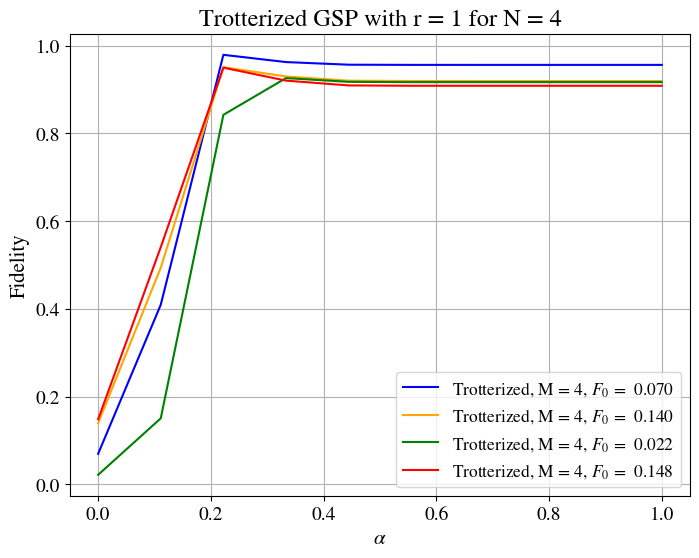

In [14]:
plot_GSP_data(ψ0_list, VTA_list, α_start, α_end, α_steps, m_start, m_stop, save_file)

In [15]:
# take the GSP operator for the first nonzero value of α
GSP = VTA_list[1]

In [16]:
# GSP is not unitary since this Boolean evaluation returns false
GSP.inv() == GSP.dag()

False